<a href="https://colab.research.google.com/github/jrbobes/jrbobes-hitl-ml/blob/master/2024_HITL_XAI_Pancreas_XGB_max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HITL_XAI_Pancreas_XGB_MAX**

authors: jose.bobes, israel.figueirido.arnoso at udc.es

XGBoost with the MAXIMUM set of parameters.

# Importing required libraries

In [1]:
# Importing Required Libraries
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import numpy as np
print('numpy: {}'.format(np.__version__))

import re
print('re: {}'.format(re.__version__))

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))

import pandas as pd
print('pandas: {}'.format(pd.__version__))

import sklearn
print('sklearn: {}'.format(sklearn.__version__))

from sklearn import metrics
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
scipy: 1.11.4
numpy: 1.25.2
re: 2.2.1
matplotlib: 3.7.1
pandas: 1.5.3
sklearn: 1.2.2


# Cleaning the Pancreas dataset

In [2]:
# 1. Set the features to be taken into account when training the models (therapy_type is the target).
features = ['ajcc_pathologic_stage',
            'ajcc_pathologic_t',
            'ajcc_pathologic_m',
            'ajcc_pathologic_n',
            'age_at_index',
            'other_dx',
            'gender',
            'race',
            'ethnicity',
            'adenocarcinoma_invasion',
            'histological_type',
            'person_neoplasm_cancer_status',
            'year_of_initial_pathologic_diagnosis',
            'initial_pathologic_diagnosis_method',
            'surgery_performed_type',
            'number_of_lymphnodes_positive_by_he',
            #'number_of_lymphnodes_positive_by_ihc',
            'neoplasm_histologic_grade',
            'maximum_tumor_dimension',
            'residual_tumor',
            'history_of_diabetes',
            'family_history_of_cancer',
            'radiation_therapy',
            'primary_therapy_outcome_success',
            'new_tumor_events',
            'days_to_new_tumor_event_after_initial_treatment',
            'therapy_type',

            # THIS NEXT 3 ARE USED with POST-TREATMENT (not to use)
            # 'postoperative_rx_tx',
            # 'tx_on_clinical_trial',
            # 'drug_name',

            'tobacco_smoking_history',
            'alcoholic_exposure_category'
]


In [3]:
# 2. Load the dataset
url = "https://raw.githubusercontent.com/jrbobes/jrbobes-hitl-ml/master/tcga_paad_datosRecomendados.csv"

dataset = pd.read_csv(url, sep=';', usecols=features, encoding = "ISO-8859-1")
dataset = dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print(dataset.shape)
print(dataset.head())

(185, 28)
  ajcc_pathologic_stage ajcc_pathologic_t ajcc_pathologic_n ajcc_pathologic_m  \
0             Stage IIB                T3                N1                MX   
1             Stage IIB                T3                N1                M0   
2              Stage IB                T2                N0                MX   
3             Stage IIA                T3                N0                M0   
4             Stage IIA                T3                N0                M0   

   age_at_index other_dx  gender   race               ethnicity  \
0            77       No    MALE  WHITE  NOT HISPANIC OR LATINO   
1            67       No    MALE  WHITE  NOT HISPANIC OR LATINO   
2            59       No  FEMALE  WHITE  NOT HISPANIC OR LATINO   
3            61       No    MALE  WHITE                     NaN   
4            65       No    MALE  WHITE  NOT HISPANIC OR LATINO   

  adenocarcinoma_invasion  ... residual_tumor history_of_diabetes  \
0                     YES  ... 

In [4]:
# 3. Show datatypes
for column, dtype in zip(dataset.columns, dataset.dtypes):
    print(f"{column}:{dtype}")

ajcc_pathologic_stage:object
ajcc_pathologic_t:object
ajcc_pathologic_n:object
ajcc_pathologic_m:object
age_at_index:int64
other_dx:object
gender:object
race:object
ethnicity:object
adenocarcinoma_invasion:object
histological_type:object
person_neoplasm_cancer_status:object
year_of_initial_pathologic_diagnosis:float64
initial_pathologic_diagnosis_method:object
surgery_performed_type:object
number_of_lymphnodes_positive_by_he:float64
neoplasm_histologic_grade:object
maximum_tumor_dimension:float64
residual_tumor:object
history_of_diabetes:object
family_history_of_cancer:object
radiation_therapy:object
primary_therapy_outcome_success:object
new_tumor_events:object
days_to_new_tumor_event_after_initial_treatment:float64
therapy_type:object
tobacco_smoking_history:float64
alcoholic_exposure_category:object


In [5]:
# 4. Missing Values/ Null Values
dataset_null = dataset.isnull()
print(dataset.isnull().sum())

ajcc_pathologic_stage                                3
ajcc_pathologic_t                                    1
ajcc_pathologic_n                                    1
ajcc_pathologic_m                                    0
age_at_index                                         0
other_dx                                             0
gender                                               0
race                                                 5
ethnicity                                           43
adenocarcinoma_invasion                              0
histological_type                                    1
person_neoplasm_cancer_status                       53
year_of_initial_pathologic_diagnosis                 1
initial_pathologic_diagnosis_method                  5
surgery_performed_type                               2
number_of_lymphnodes_positive_by_he                  4
neoplasm_histologic_grade                            0
maximum_tumor_dimension                             15
residual_t

In [6]:
# 5. Fill in the missing values
dataset.ajcc_pathologic_stage = dataset.ajcc_pathologic_stage.fillna('Stage 0')
dataset.ajcc_pathologic_t = dataset.ajcc_pathologic_t.fillna('TX')
dataset.ajcc_pathologic_m = dataset.ajcc_pathologic_m.fillna('MX')
dataset.ajcc_pathologic_n = dataset.ajcc_pathologic_n.fillna('NX')
dataset.race = dataset.race.fillna('Unknown')
dataset.ethnicity = dataset.ethnicity.fillna('Unknown')
dataset.person_neoplasm_cancer_status = dataset.person_neoplasm_cancer_status.fillna('Unknown')
dataset.therapy_type = dataset.therapy_type.fillna('Other')
dataset.number_of_lymphnodes_positive_by_he = dataset.number_of_lymphnodes_positive_by_he.fillna(dataset.number_of_lymphnodes_positive_by_he.mean())
#dataset.number_of_lymphnodes_positive_by_ihc = dataset.number_of_lymphnodes_positive_by_ihc.fillna(dataset.number_of_lymphnodes_positive_by_ihc.mean())
dataset.days_to_new_tumor_event_after_initial_treatment = dataset.days_to_new_tumor_event_after_initial_treatment.fillna(dataset.days_to_new_tumor_event_after_initial_treatment.mean())
dataset.tobacco_smoking_history = dataset.tobacco_smoking_history.fillna(0)
dataset.alcoholic_exposure_category = dataset.alcoholic_exposure_category.fillna('None')

dataset.histological_type = dataset.histological_type.fillna('None')
dataset.person_neoplasm_cancer_status = dataset.person_neoplasm_cancer_status.fillna('Unknown')
dataset.year_of_initial_pathologic_diagnosis = dataset.year_of_initial_pathologic_diagnosis.fillna(dataset.year_of_initial_pathologic_diagnosis.mean())
dataset.initial_pathologic_diagnosis_method = dataset.initial_pathologic_diagnosis_method.fillna('Unknown')
dataset.surgery_performed_type = dataset.surgery_performed_type.fillna('Unknown')
dataset.maximum_tumor_dimension = dataset.maximum_tumor_dimension.fillna(dataset.maximum_tumor_dimension.mean())
dataset.residual_tumor = dataset.residual_tumor.fillna('Unknown')
dataset.history_of_diabetes = dataset.history_of_diabetes.fillna('Unknown')
dataset.family_history_of_cancer = dataset.family_history_of_cancer.fillna('Unknown')
dataset.radiation_therapy = dataset.radiation_therapy.fillna('Unknown')

# THIS NEXT 3 ARE USED with POST-TREATMENT (turn on-off conveniently)
# dataset.postoperative_rx_tx = dataset.postoperative_rx_tx.fillna('Unknown')
# dataset.tx_on_clinical_trial = dataset.tx_on_clinical_trial.fillna('Unknown')
# dataset.drug_name = dataset.drug_name.fillna('None')

dataset.primary_therapy_outcome_success = dataset.primary_therapy_outcome_success.fillna('Unknown')
dataset.new_tumor_events = dataset.new_tumor_events.fillna('Unknown')

dataset_null = dataset.isnull()
print(dataset.isnull().sum())

ajcc_pathologic_stage                              0
ajcc_pathologic_t                                  0
ajcc_pathologic_n                                  0
ajcc_pathologic_m                                  0
age_at_index                                       0
other_dx                                           0
gender                                             0
race                                               0
ethnicity                                          0
adenocarcinoma_invasion                            0
histological_type                                  0
person_neoplasm_cancer_status                      0
year_of_initial_pathologic_diagnosis               0
initial_pathologic_diagnosis_method                0
surgery_performed_type                             0
number_of_lymphnodes_positive_by_he                0
neoplasm_histologic_grade                          0
maximum_tumor_dimension                            0
residual_tumor                                

In [7]:
# 6. Removing Redundancy
count_duplicates = dataset[dataset.duplicated()].shape[0]
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 0


In [8]:
# There are NO duplicates with the columns selected.
dataset[dataset.duplicated()]

,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_pathologic_n,ajcc_pathologic_m,age_at_index,other_dx,gender,race,ethnicity,adenocarcinoma_invasion,...,residual_tumor,history_of_diabetes,family_history_of_cancer,radiation_therapy,primary_therapy_outcome_success,new_tumor_events,days_to_new_tumor_event_after_initial_treatment,therapy_type,tobacco_smoking_history,alcoholic_exposure_category


# Data Preparation

In [9]:
# 0. Check the current different therapy types
dataset['therapy_type'].unique()

array(['Chemotherapy', 'Other', 'Vaccine', 'Ancillary', 'Hormone Therapy'],
      dtype=object)

In [10]:
# 1. Simplify Target with only Chemotherapy or Other
dataset['therapy_type'] = dataset['therapy_type'].replace('Hormone Therapy', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Vaccine', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Ancillary', 'Other')

# check that we only get two values: 'Chemotherapy' and 'Other'
dataset['therapy_type'].unique()

array(['Chemotherapy', 'Other'], dtype=object)

In [11]:
# 2. Convert categorical variables into numerical.
# Categorical features need to be transformed before they can be used in a model.

dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage 0', 0)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage I', 1)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IA', 2)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IB', 3)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage II', 4)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIA', 5)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIB', 6)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage III', 7)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IV', 8)

dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('TX', 0)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T1', 1)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T2', 2)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T3', 3)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T4', 4)

dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N0', 0)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1', 1)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1b', 2)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('NX', 3)

dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M0', 0)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M1', 1)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('MX', 2)

In [12]:
# 3. Drop unneeded Features
# Remove therapy_type from the X vector, and keep it as the target.
X = dataset.drop(['therapy_type'], axis=1)
y = dataset['therapy_type']

In [13]:
# 4. Use One-hot encoding for the rest of categorical features. We get a binary variable for each category.
X_encoded = pd.get_dummies(X)

In [14]:
# 5. Split the data in train and test sets
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size=0.3,random_state=42)

# Create a XGBClassifier model

In [15]:
# 1. Create a XGBClassifier model
import xgboost as xgb

y_train[y_train == 'Other'] = 0
y_train[y_train == 'Chemotherapy'] = 1

y_test[y_test == 'Other'] = 0
y_test[y_test == 'Chemotherapy'] = 1

xgb_clf = xgb.XGBClassifier(objective="binary:logistic", max_depth=10, n_estimators=40)  #mejor que 2, 50 (REVISAR!)
xgb_clf = xgb_clf.fit(X_train, y_train)

In [16]:
# 2. Predict the response for test dataset
y_xgb_pred = xgb_clf.predict(X_test)

In [17]:
# error obtaining accuracy score: https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
# Possible solution: https://stackoverflow.com/questions/65585364/one-class-svm-classification-error-classification-metrics-cant-handle-a-mix-o
y_test = y_test.astype('int')

xgb_acc = metrics.accuracy_score(y_test, y_xgb_pred)
print("XGBOOST accuracy: ", xgb_acc)
# 3. Get a different metrics report
print(metrics.classification_report(y_test, y_xgb_pred))
# TODO(?): ¿cross validation score?

XGBOOST accuracy:  0.5535714285714286
              precision    recall  f1-score   support

           0       0.58      0.26      0.36        27
           1       0.55      0.83      0.66        29

    accuracy                           0.55        56
   macro avg       0.56      0.54      0.51        56
weighted avg       0.56      0.55      0.51        56



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

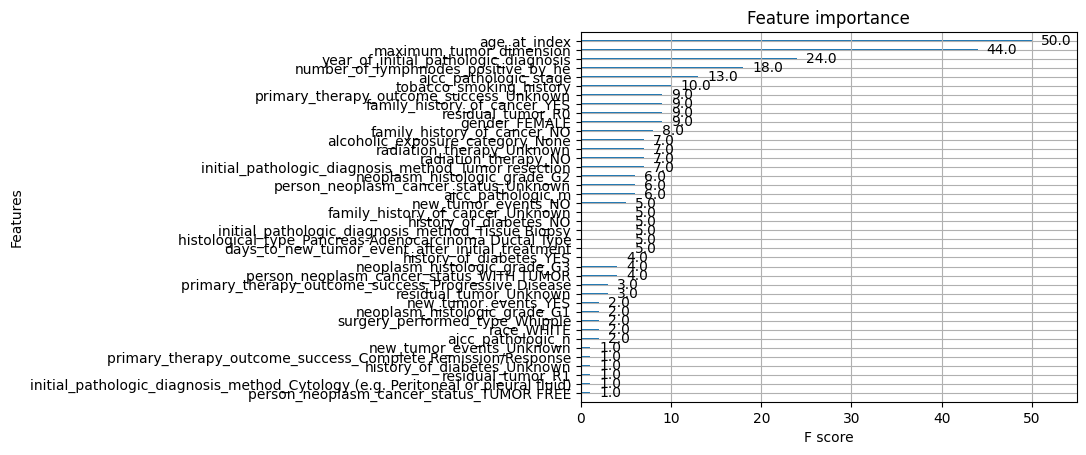

In [18]:
from xgboost import plot_importance
plot_importance(xgb_clf, max_num_features=40)
#pyplot.bar(range(len(xgb_clf.feature_importances_)), xgb_clf.feature_importances_)
#pyplot.show()

In [19]:
# plot
importances = xgb_clf.feature_importances_    #'gain' type of feature importance by default
pd.Series(importances, index=X_encoded.columns).sort_values(ascending=False)

race_BLACK OR AFRICAN AMERICAN                                                     0.122872
race_WHITE                                                                         0.110928
initial_pathologic_diagnosis_method_Cytology (e.g. Peritoneal or pleural fluid)    0.062263
residual_tumor_R0                                                                  0.045918
ethnicity_NOT HISPANIC OR LATINO                                                   0.043467
                                                                                     ...   
surgery_performed_type_Other Method                                                0.000000
surgery_performed_type_Total Pancreatectomy                                        0.000000
surgery_performed_type_Unknown                                                     0.000000
neoplasm_histologic_grade_G4                                                       0.000000
alcoholic_exposure_category_Weekly Drinker                                      

#Permutation Importance

Permutation Importance is an algorithm that computes importance scores
for each of the feature variables of a dataset. The importance measures are determined by computing the sensitivity of a model to random permutations of feature values.

It measures the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature.

In [ ]:
# 1. Install required package
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=73519a5b68dd5c03c85ddc7868db7779b454739bfa42e6784bdea98f15b052fa
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
# 2. Get permutation importance data and show weights
xgb_perm = PermutationImportance(xgb_clf, random_state=42).fit(X_test, y_test)
eli5.show_weights(xgb_perm, feature_names = X_encoded.columns.tolist())

Weight,Feature
0.0286 ± 0.0769,family_history_of_cancer_YES
0.0179 ± 0.0000,gender_FEMALE
0.0179 ± 0.0505,ajcc_pathologic_stage
0.0143 ± 0.0143,histological_type_Pancreas-Adenocarcinoma Ductal Type
0.0071 ± 0.0175,new_tumor_events_NO
0.0036 ± 0.0267,residual_tumor_R0
0.0036 ± 0.0143,radiation_therapy_Unknown
0.0036 ± 0.0143,neoplasm_histologic_grade_G3
0.0000 ± 0.0598,maximum_tumor_dimension
0 ± 0.0000,ajcc_pathologic_t


In [ ]:
# 3. Patient 3 data
#eli5.show_prediction(xgb_clf, X_train.iloc[2])

In [ ]:
# 4. Patient 4 data
#eli5.show_prediction(xgb_clf, X_train.iloc[3])

# Explainability with SHAP

In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 12.0 MB/s eta 0:00:00


In [ ]:
# Explain the model's predictions using SHAP
explainerShap = shap.TreeExplainer(xgb_clf)

# Compute shap_values for X_test
shap_values = explainerShap.shap_values(X_test)

**Pacient 3**
Get the data from patient 3

In [ ]:
paciente3 = X_encoded.loc[[2]]
paciente3

,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_pathologic_n,ajcc_pathologic_m,age_at_index,year_of_initial_pathologic_diagnosis,number_of_lymphnodes_positive_by_he,maximum_tumor_dimension,days_to_new_tumor_event_after_initial_treatment,tobacco_smoking_history,...,primary_therapy_outcome_success_Stable Disease,primary_therapy_outcome_success_Unknown,new_tumor_events_NO,new_tumor_events_Unknown,new_tumor_events_YES,alcoholic_exposure_category_Daily Drinker,alcoholic_exposure_category_None,alcoholic_exposure_category_Occasional Drinker,alcoholic_exposure_category_Social Drinker,alcoholic_exposure_category_Weekly Drinker
2,3,2,0,2,59,2011.0,0.0,3.0,388.301887,1.0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
y[2]

'Other'

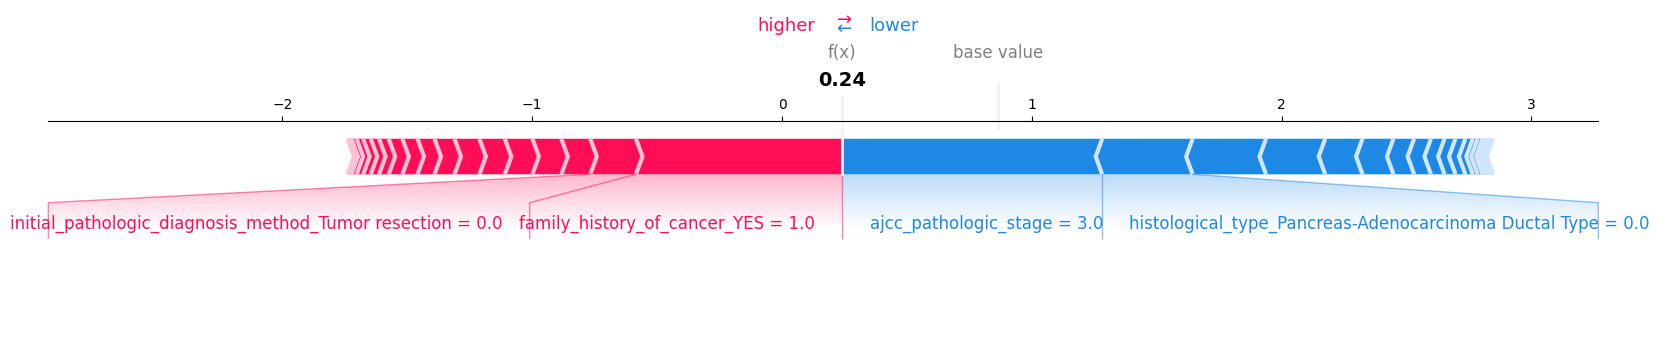

In [ ]:
shap.initjs()
paciente3_shap_values = explainerShap.shap_values(paciente3)

shap.force_plot(explainerShap.expected_value, paciente3_shap_values, paciente3, matplotlib = True, show=False)

In [ ]:
#plt.savefig("shap_paciente3.png")
plt.close()

Paciente 4

In [ ]:
paciente4 = X_encoded.loc[[3]]
paciente4

,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_pathologic_n,ajcc_pathologic_m,age_at_index,year_of_initial_pathologic_diagnosis,number_of_lymphnodes_positive_by_he,maximum_tumor_dimension,days_to_new_tumor_event_after_initial_treatment,tobacco_smoking_history,...,primary_therapy_outcome_success_Stable Disease,primary_therapy_outcome_success_Unknown,new_tumor_events_NO,new_tumor_events_Unknown,new_tumor_events_YES,alcoholic_exposure_category_Daily Drinker,alcoholic_exposure_category_None,alcoholic_exposure_category_Occasional Drinker,alcoholic_exposure_category_Social Drinker,alcoholic_exposure_category_Weekly Drinker
3,5,3,0,0,61,2011.0,0.0,2.2,388.301887,1.0,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
y[3]

'Chemotherapy'

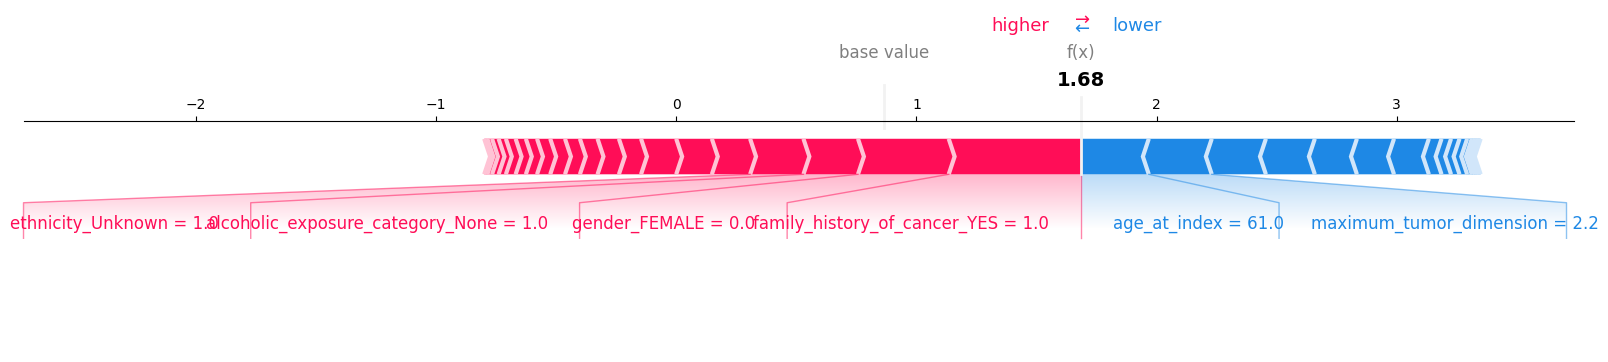

In [ ]:
paciente4_shap_values = explainerShap.shap_values(paciente4)

shap.force_plot(explainerShap.expected_value, paciente4_shap_values, paciente4, matplotlib = True, show=False)

Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect.

Feature values in blue causse to decrease the prediction. Sum of all feature SHAP values explain why model prediction was different from the baseline.

In [ ]:
#plt.savefig("shap_paciente4.png")
plt.close()

Summary plot will give us the variable importance plot. Features with high predicting power are shown at the top and the ones with low predicting powers are shown at the bottom.

We could see the contribution of each data into the prediction probability. The redder the colour, the higher the value and vice versa. Also, when the value is on the positive side, it contributes to the class 0 prediction result probability and vice versa.

Variable Importance Plot - Global Interpretation


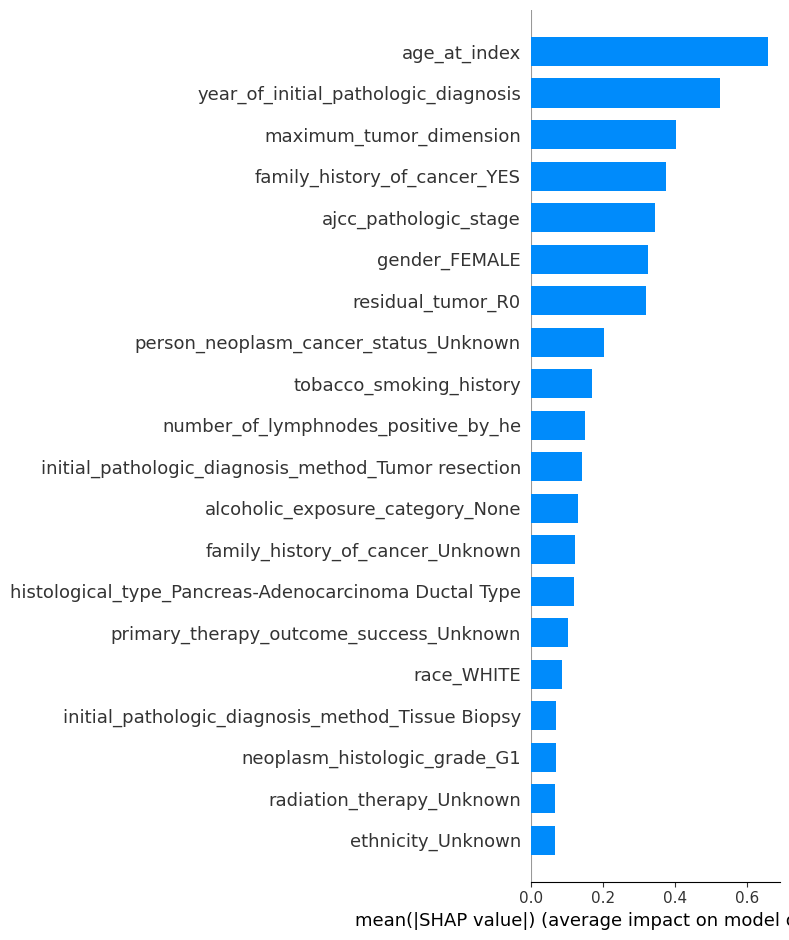

In [ ]:
# Variable importance plot: same for 2 output classes --> https://datascience.stackexchange.com/questions/116979/shap-summary-plot-for-binary-classification-and-multiclass
print("Variable Importance Plot - Global Interpretation")
shap.summary_plot(shap_values, X_test, plot_type='bar', class_names=['Chemotherapy','Other'])

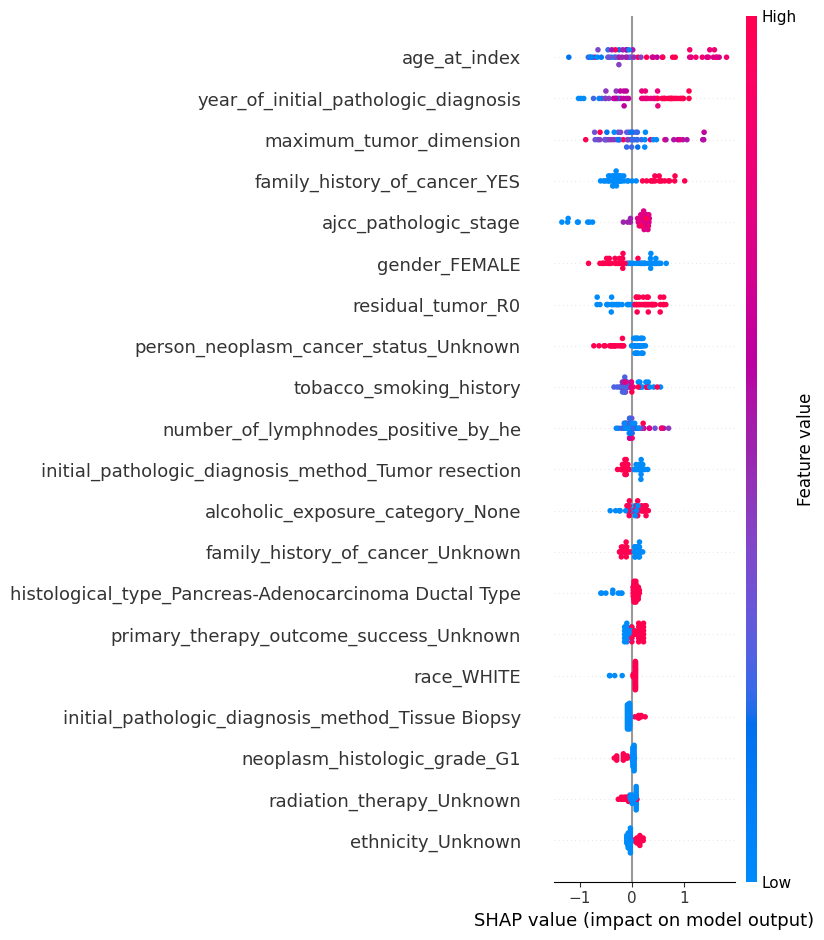

In [ ]:
# Summary plot in an individual sample
shap.summary_plot(shap_values, X_test)

The **partial dependence plot** is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

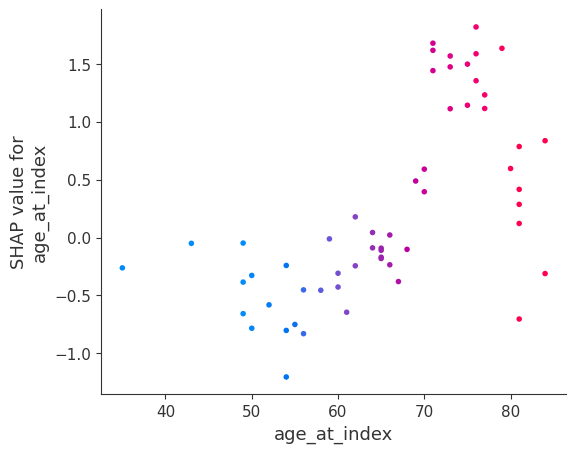

In [ ]:
shap.dependence_plot('age_at_index', shap_values, X_test, interaction_index='age_at_index')

A continuación incluimos un gráfico de decisión:

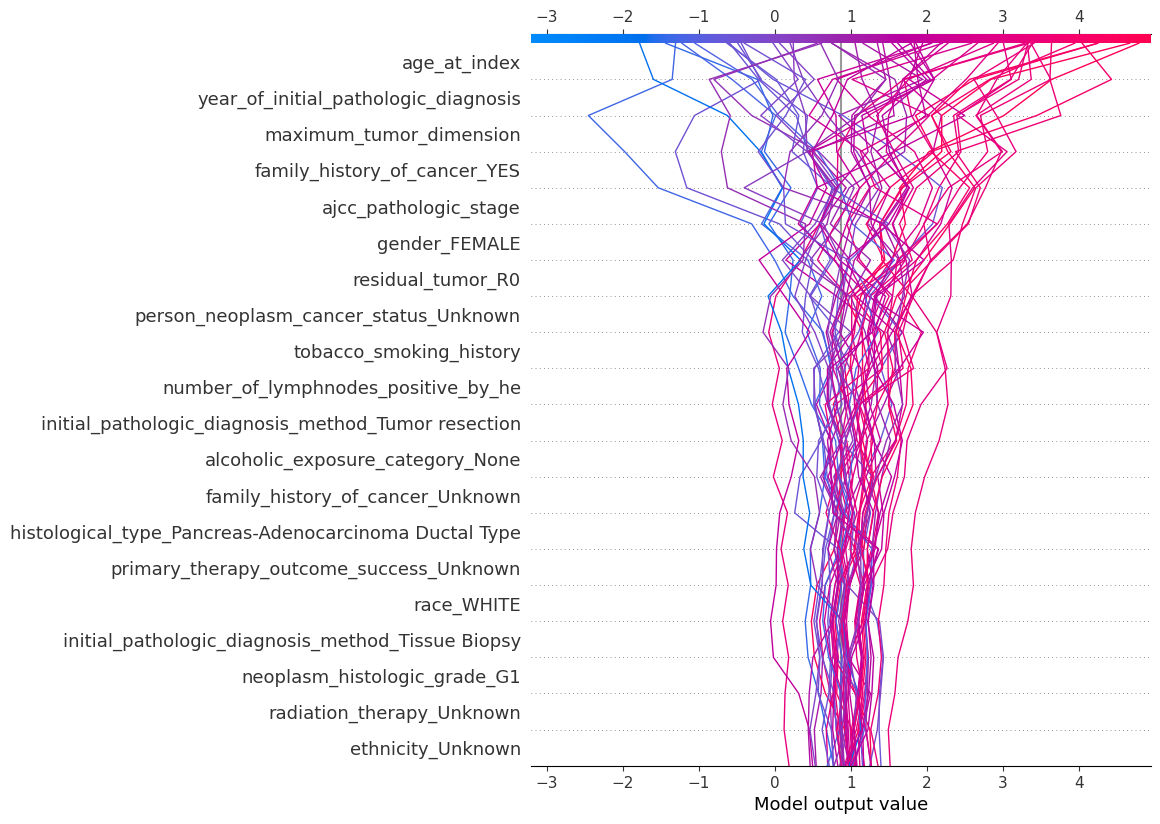

In [ ]:
shap.decision_plot(explainerShap.expected_value, shap_values, feature_names = list(X_encoded.columns))

Y finalmente un gráfico de fuerzas:

In [ ]:
shap.initjs()
shap.force_plot(explainerShap.expected_value, shap_values, feature_names = list(X_encoded.columns))

# Explainability with LIME

LIME (Local Interpretable Model-Agnostic Explanations) is a method for explaining the predictions of any classifier and regressor (model agnostic).

In [20]:
# Install SHAP (SHapley Additive exPlanations).
!pip install lime

# Import required libraries
from lime.lime_tabular import LimeTabularExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a03a0055290b19e58870f9f9b89d74fa66f6471ba9cf16db5a60a4b93e1ef3cb
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [21]:
# XAI with LIME (Local Interpretable Model-agnostic Explanations)
explainerLime = LimeTabularExplainer(X_encoded.values, feature_names=X_encoded.columns, class_names = ['Chemotherapy', 'Other'], discretize_continuous=True)
#explainer2 = LimeTabularExplainer(X_encoded.values[:,:], feature_names = X_encoded.columns,class_names=['Chemotherapy','Other'], discretizer='decile',kernel_width=5,discretize_continuous=True,verbose=True)

# Patient 3 LIME explanation
expPatient3 = explainerLime.explain_instance(X_encoded.values[2], xgb_clf.predict_proba, num_features=10, top_labels=5)
#exp2 = explainer2.explain_instance(X_encoded.iloc[1,:],rf_clf.predict_proba)

expPatient3.show_in_notebook(show_all=True)
expPatient3.as_pyplot_figure()
plt.close()

In [22]:
# Patient 4 LIME explanation
#expPatient4 = explainerLime.explain_instance(X_encoded.values[3], xgb_clf.predict_proba, num_features=10, top_labels=3)
#expPatient4.show_in_notebook(show_all=True)
#expPatient4.as_pyplot_figure()
#plt.close()

In [23]:
import warnings
warnings.filterwarnings('ignore')

#Get the overall most common important features
feature_importance = {}
# Get, for each patient, the most important feature
for idx, i in enumerate(X_encoded.values): #X_encoded.values[:3]
  expl = explainerLime.explain_instance(i, xgb_clf.predict_proba, num_features=20, top_labels=20)

  # Iterate over the set of features
  for jdx, j in enumerate(expl.as_list()):

    # Get feature and value
    splitedj = str(j[0]).split()
    if (len(splitedj) == 5):
      feature_name = splitedj[2]
    else:
      feature_name = splitedj[0]

    feature_importance_value = abs(j[1])

    #print(str(idx) + "-" + str(jdx) + " - feature: " + feature_name + " = " + str(feature_importance_value))

    # Add new value to the feature (average)
    if feature_name in feature_importance:
      previous_value = feature_importance[feature_name]
      new_value = (previous_value + feature_importance_value) / 2
      #print("  *previous_value = " + str(previous_value) + " / new value = " + str(new_value))
    else:
      new_value = feature_importance_value
      #print("new value = " + str(feature_importance_value))

    feature_importance[feature_name] = new_value

# Print dictionary order by feature importance value
dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse = True))

{'age_at_index': 0.17553203400663503,
 'ajcc_pathologic_stage': 0.15681874862299194,
 'family_history_of_cancer_YES': 0.14858337512764475,
 'year_of_initial_pathologic_diagnosis': 0.10444725082505524,
 'residual_tumor_R0': 0.09162492551624249,
 'race_BLACK': 0.08527351065742922,
 'residual_tumor_Unknown': 0.08329822524486284,
 'family_history_of_cancer_Unknown': 0.0751739586373149,
 'gender_FEMALE': 0.06789681712880852,
 'initial_pathologic_diagnosis_method_Other': 0.06597386529327512,
 'surgery_performed_type_Unknown': 0.06593497947929199,
 'neoplasm_histologic_grade_GX': 0.062314623134356775,
 'person_neoplasm_cancer_status_Unknown': 0.057214128786884054,
 'maximum_tumor_dimension': 0.05545855832774965,
 'number_of_lymphnodes_positive_by_he': 0.052257286326889155,
 'histological_type_None': 0.0497796596690402,
 'adenocarcinoma_invasion_NO': 0.049756942726427666,
 'histological_type_Pancreas-Colloid': 0.04827605324420689,
 'tobacco_smoking_history': 0.04376275707641346,
 'surgery_perf